[1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

We will use Area under the curve and ROC, since we are really just looking for the best model, there is no priority on false/true positives vs false/true negatives that would be needed to use recall or precision __TODO__

[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

We will use Stratified k-fold sampling, because it is best __TODO__

In [75]:
import keras
import os
import struct
import numpy as np
import tensorflow as tf
# from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, MaxPooling2D, Conv2D, Dense, Flatten, Activation
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model


def load_dataset(path):
    images = []
    labels = []
    label_classes = os.listdir(path)
    for label in label_classes:
        img_names = os.listdir(os.path.join(path, label))
        for img_name in img_names:
            img = cv2.imread(os.path.join(path, label, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

X, y = load_dataset('1000pc_parts')

# Normalize the images.
X = X.reshape(X.shape[0], 28, 28, 1) / 255.0 - 0.5

# Use LabelEncoder to encode labels into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Number of classes
NUM_CLASSES = len(np.unique(y))

# One-hot encode the labels
y_ohe = to_categorical(y, NUM_CLASSES)

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#use this for training the thing
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y_ohe[train_index], y_ohe[test_index]
#     # Now you can train your model on X_train, y_train and validate it on X_test, y_test

In [76]:

%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        
        
        y_test_int = np.argmax(y_test, axis=1)  # Convert y_test to integer labels
        acc_cnn = mt.accuracy_score(y_test_int,yhat_cnn)
        
        
        # acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        # cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = mt.confusion_matrix(y_test_int,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'CNN: {acc_cnn:.4f}')
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        
        
        y_test_int = np.argmax(y_test, axis=1)  # Convert y_test to integer labels
        acc_mlp = mt.accuracy_score(y_test_int,yhat_cnn)
        
        
        # acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test_int,yhat_mlp)
        # cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'MLP: {acc_mlp:.4f}')
labels = [
    "speakers",
    "webcam",
    "mouse",
    "keyboard",
    "microphone",
    "headset",
    "cpu",
    "gpu",
]

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

Below, we use a horizontal flip and random rotation __TODO__ Explain why this works for our pictures of pc parts

In [77]:
# %%time
# Define data augmentation

data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
])
# make a keras MLP
def createMLP():
        mlp = Sequential()
        mlp.add(data_augmentation)
        mlp.add( Flatten() )
        mlp.add( Dense(input_dim=1, units=100, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(NUM_CLASSES) )
        mlp.add( Activation('softmax') )

        mlp.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

        input_shape = [None, 28,28,1]
        mlp.build(input_shape)
        return mlp

        # mlp.fit(X_train, y_train_ohe, 
        #         batch_size=32, epochs=3, 
        #         shuffle=True, verbose=1)

In [78]:



def createCNN1():
    cnn1 = Sequential()
    cnn1.add(data_augmentation)
    num_filt_layers = [24, 24]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                            ) )
        

    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(100, activation='relu') )
    cnn1.add( Dense(100, activation='relu') )
    cnn1.add( Dense(NUM_CLASSES, activation='softmax') )
    
    cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  
    input_shape = [None, 28,28,1]
    cnn1.build(input_shape)  
    return cnn1

def createCNN2():
    cnn2 = Sequential()
    cnn2.add(data_augmentation)
    # let's start with an AlexNet style convolutional phase
    cnn2.add(Conv2D(filters=32,
                    input_shape = (28,28,1),
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax

    # no max pool before next conv layer!!
    cnn2.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax
    cnn2.add(MaxPooling2D(pool_size=(2, 2)))
        

    # add one layer on flattened output
    cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn2.add(Flatten())
    cnn2.add(Dense(128, activation='relu'))
    cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

    # Let's train the model 
    cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    input_shape = [None, 28,28,1]
    cnn2.build(input_shape)  
    return cnn2
def createCNN3():
    cnn3 = Sequential()
    cnn3.add(data_augmentation)
    num_filt_layers = [32, 32]  # Changed number of filters
    for num_filters in num_filt_layers:
        cnn3.add(Conv2D(filters=num_filters, 
                        kernel_size=(5,5),  # Changed kernel size
                        padding='same'))
        cnn3.add(Activation('relu'))
        cnn3.add(MaxPooling2D(pool_size=(2, 2)))

    # add one layer on flattened output
    cnn3.add(Flatten())
    cnn3.add(Dense(128, activation='relu'))  # Changed number of neurons
    cnn3.add(Dense(128, activation='relu'))  # Changed number of neurons
    cnn3.add(Dense(NUM_CLASSES, activation='softmax'))
    
    cnn3.compile(loss='mean_squared_error',
              optimizer='adam',  # Changed optimizer
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  
    input_shape = [None, 28,28,1]
    cnn3.build(input_shape)  
    return cnn3

def createCNN4():
    cnn4 = Sequential()
    cnn4.add(data_augmentation)
    cnn4.add(Conv2D(filters=48,  # Changed number of filters
                    input_shape = (28,28,1),
                    kernel_size=(5,5),  # Changed kernel size
                    padding='same', 
                    activation='relu'))

    cnn4.add(Conv2D(filters=96,  # Changed number of filters
                    kernel_size=(5,5),  # Changed kernel size
                    padding='same', 
                    activation='relu'))
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))

    cnn4.add(Dropout(0.3))  # Changed dropout rate
    cnn4.add(Flatten())
    cnn4.add(Dense(256, activation='relu'))  # Changed number of neurons
    cnn4.add(Dropout(0.5)) 
    cnn4.add(Dense(NUM_CLASSES, activation='softmax'))

    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',  # Changed optimizer
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    input_shape = [None, 28,28,1]
    cnn4.build(input_shape)  
    return cnn4


[2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

__TODO__ See that the models converge (need more epochs), we should probably reduce the number of n_splits to run it faster.

In [79]:
import matplotlib.pyplot as plt

def plot_histories(histories, labels):
    # Create new labels list with labels for both training and validation lines
    new_labels = [f'{label} Train' for label in labels] + [f'{label} Validation' for label in labels]

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(new_labels, loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(new_labels, loc='upper left')
    plt.show()

In [80]:
# %%time
# Define data augmentation

data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
])
# make a keras MLP
def createMLP():
        mlp = Sequential()
        mlp.add(data_augmentation)
        mlp.add( Flatten() )
        mlp.add( Dense(input_dim=1, units=100, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(units=50, activation='relu') )
        mlp.add( Dense(NUM_CLASSES) )
        mlp.add( Activation('softmax') )

        mlp.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

        input_shape = [None, 28,28,1]
        mlp.build(input_shape)
        return mlp

        # mlp.fit(X_train, y_train_ohe, 
        #         batch_size=32, epochs=3, 
        #         shuffle=True, verbose=1)

In [81]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


def TransferCNN():
    # Load pre-trained MobileNet model without the top layers
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a logistic layer with the number of classes
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model (we won't update the weights during training)
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    return model



__TODO__ explain that our laptops are not good enough to run it with 10 splits, so I did 2 splits, and also explain that it takes too long to see how far each model should go so I just chose 10 for them all (addy please take the time to comment out all of them, increase the epoch amount, and choose the point where they start to converge)

X_train shape: (1639, 28, 28, 1)
X_test shape: (1640, 28, 28, 1)
y_train shape: (1639, 14)
y_test shape: (1640, 14)


c:\Users\jadon\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\jadon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


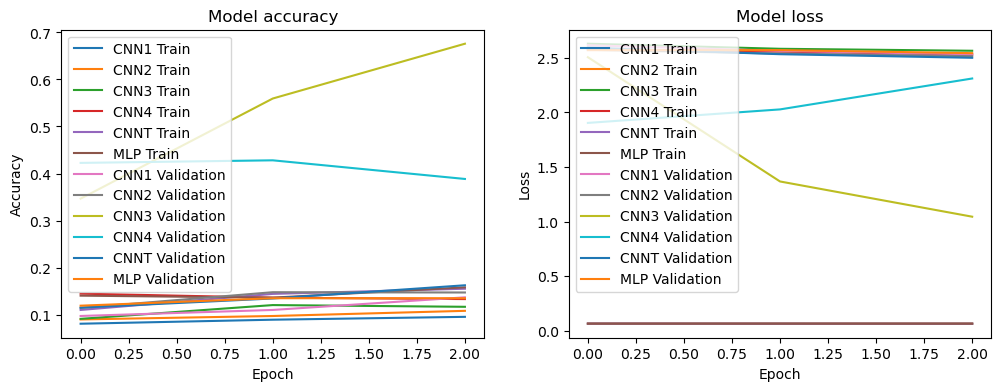

X_train shape: (1640, 28, 28, 1)
X_test shape: (1639, 28, 28, 1)
y_train shape: (1640, 14)
y_test shape: (1639, 14)


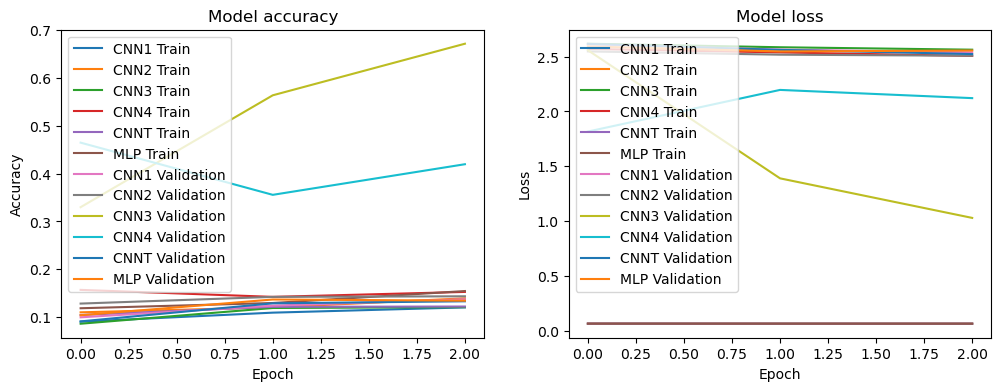

Average AUC for CNN1: 0.5976850390434265
Average AUC for CNN2: 0.6525300145149231
Average AUC for CNN3: 0.6422938108444214
Average AUC for CNN4: 0.6504287123680115
Average AUC for CNNT: 0.8415640592575073
Average AUC for MLP: 0.6322807669639587
Average accuracy for CNN1: 0.12351801991462708
Average accuracy for CNN2: 0.14272943139076233
Average accuracy for CNN3: 0.1561446189880371
Average accuracy for CNN4: 0.14516565948724747
Average accuracy for CNNT: 0.40409138798713684
Average accuracy for MLP: 0.13449214398860931


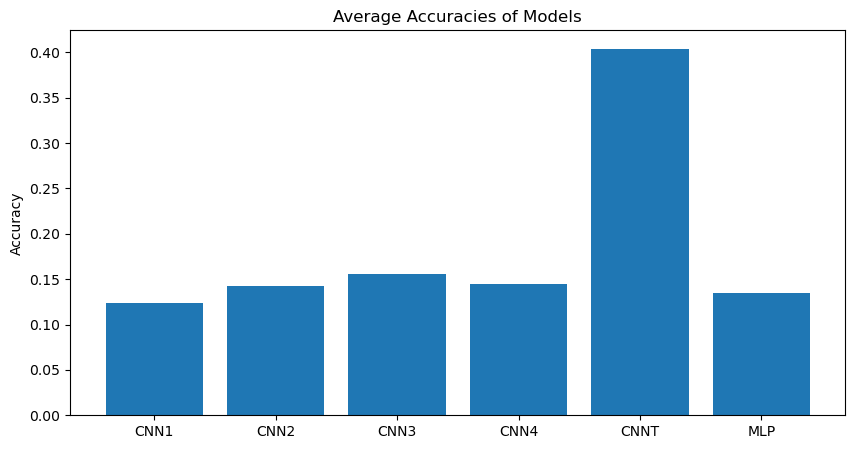

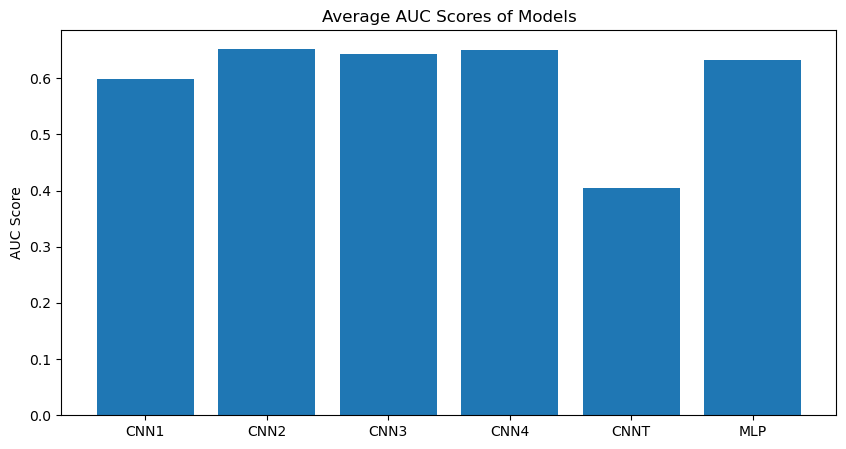

p-value for CNN1 vs CNN2 accuracies: 0.18631211818874657
p-value for CNN1 vs CNN3 accuracies: 0.3114993021479852
p-value for CNN1 vs CNN4 accuracies: 0.4306034114148165
p-value for CNN1 vs MLP accuracies: 0.6145666219654548
p-value for CNN2 vs CNN3 accuracies: 0.45347265207799997
p-value for CNN2 vs CNN4 accuracies: 0.8680817311558056
p-value for CNN2 vs MLP accuracies: 0.563412549062108
p-value for CNN3 vs CNN4 accuracies: 0.0001939792985522006
p-value for CNN3 vs MLP accuracies: 0.044566186978136295
p-value for CNN4 vs MLP accuracies: 0.09014781964398884


In [82]:

# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cnn1_accuracies = []
cnn2_accuracies = []
cnn3_accuracies = []
cnn4_accuracies = []
cnnT_accuracies = []
mlp_accuracies = []
cnn1_auc_scores = []
cnn2_auc_scores = []
cnn3_auc_scores = []
cnn4_auc_scores = []
cnnT_auc_scores = []
mlp_auc_scores = []
#use this for training the thing
es = 3
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_ohe[train_index], y_ohe[test_index]
    print('X_train shape:', X_train.shape) 
    print('X_test shape:', X_test.shape)

    print('y_train shape:', y_train.shape) 
    print('y_test shape:', y_test.shape)
    # Train and evaluate the first CNN
    cnn1 = createCNN1()
    history1 = cnn1.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn1_accuracies.append(history1.history['val_accuracy'][-1])
    cnn1_auc_scores.append(history1.history['val_auc'][-1])  # Extract AUC from history


    # Train and evaluate the second CNN
    cnn2 = createCNN2()
    history2 = cnn2.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn2_accuracies.append(history2.history['val_accuracy'][-1])
    cnn2_auc_scores.append(history2.history['val_auc'][-1])  # Extract AUC from history
    
    # Train and evaluate the third CNN
    cnn3 = createCNN3()
    history3 = cnn3.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn3_accuracies.append(history3.history['val_accuracy'][-1])
    cnn3_auc_scores.append(history3.history['val_auc'][-1])

    # Train and evaluate the fourth CNN
    cnn4 = createCNN4()
    history4 = cnn4.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test,y_test))
    cnn4_accuracies.append(history4.history['val_accuracy'][-1])
    cnn4_auc_scores.append(history4.history['val_auc'][-1])

    # Train and evaluate the MLP
    mlp = createMLP()
    # history_mlp = mlp.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0)
    history_mlp = mlp.fit(X_train, y_train, batch_size=32, epochs=es, shuffle=True, verbose=0, validation_data=(X_test, y_test))
    mlp_accuracies.append(history_mlp.history['val_accuracy'][-1])
    mlp_auc_scores.append(history_mlp.history['val_auc'][-1])  # Extract AUC from history
    
    cnnT = TransferCNN()
    # Resize and convert images to RGB
    X_train_rgb = np.array([cv2.cvtColor(cv2.resize(img.astype('float32'), (128, 128)), cv2.COLOR_GRAY2RGB) for img in X_train])
    X_test_rgb = np.array([cv2.cvtColor(cv2.resize(img.astype('float32'), (128, 128)), cv2.COLOR_GRAY2RGB) for img in X_test])

    # Now, you can use these RGB images to train your model
    historyT = cnnT.fit(X_train_rgb, y_train, epochs=es, verbose=0, validation_data=(X_test_rgb, y_test))
    cnnT_accuracies.append(historyT.history['val_accuracy'][-1])
    cnnT_auc_scores.append(historyT.history['val_auc'][-1])
        
    # Assuming history1, history2, history3, history4, and history_mlp are the history objects for cnn1, cnn2, cnn3, cnn4, and mlp respectively
    plot_histories([history1, history2, history3, history4, historyT, history_mlp], ['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP'])
    # plot_histories([history1, history_mlp], ['CNN1', 'MLP'])
    
    
    
# Compute average AUC and accuracy for each model
avg_auc_cnn1 = np.mean(cnn1_auc_scores)
avg_auc_cnn2 = np.mean(cnn2_auc_scores)
avg_auc_cnn3 = np.mean(cnn3_auc_scores)
avg_auc_cnn4 = np.mean(cnn4_auc_scores)
avg_auc_cnnT = np.mean(cnnT_auc_scores)
avg_auc_mlp = np.mean(mlp_auc_scores)

avg_acc_cnn1 = np.mean(cnn1_accuracies)
avg_acc_cnn2 = np.mean(cnn2_accuracies)
avg_acc_cnn3 = np.mean(cnn3_accuracies)
avg_acc_cnn4 = np.mean(cnn4_accuracies)
avg_acc_cnnT = np.mean(cnnT_accuracies)
avg_acc_mlp = np.mean(mlp_accuracies)

# Print average AUC and accuracy for each model
print('Average AUC for CNN1:', avg_auc_cnn1)
print('Average AUC for CNN2:', avg_auc_cnn2)
print('Average AUC for CNN3:', avg_auc_cnn3)
print('Average AUC for CNN4:', avg_auc_cnn4)
print('Average AUC for CNNT:', avg_auc_cnnT)
print('Average AUC for MLP:', avg_auc_mlp)

print('Average accuracy for CNN1:', avg_acc_cnn1)
print('Average accuracy for CNN2:', avg_acc_cnn2)
print('Average accuracy for CNN3:', avg_acc_cnn3)
print('Average accuracy for CNN4:', avg_acc_cnn4)
print('Average accuracy for CNNT:', avg_acc_cnnT)
print('Average accuracy for MLP:', avg_acc_mlp)

import matplotlib.pyplot as plt

# Average accuracies
plt.figure(figsize=(10, 5))
plt.bar(['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP'], [avg_acc_cnn1, avg_acc_cnn2, avg_acc_cnn3, avg_acc_cnn4, avg_acc_cnnT, avg_acc_mlp])
plt.title('Average Accuracies of Models')
plt.ylabel('Accuracy')
plt.show()

# Average AUC scores
plt.figure(figsize=(10, 5))
plt.bar(['CNN1', 'CNN2', 'CNN3', 'CNN4','CNNT', 'MLP'], [avg_auc_cnn1, avg_auc_cnn2, avg_auc_cnn3, avg_auc_cnn4, avg_acc_cnnT, avg_auc_mlp])
plt.title('Average AUC Scores of Models')
plt.ylabel('AUC Score')
plt.show()

from scipy import stats

# List of all models' accuracies
accuracies = [cnn1_accuracies, cnn2_accuracies, cnn3_accuracies, cnn4_accuracies, mlp_accuracies]
labels = ['CNN1', 'CNN2', 'CNN3', 'CNN4', 'MLP']

# Compare accuracies of all pairs of models
for i in range(len(accuracies)):
    for j in range(i+1, len(accuracies)):
        t_stat, p_val = stats.ttest_rel(accuracies[i], accuracies[j])
        print(f'p-value for {labels[i]} vs {labels[j]} accuracies: {p_val}')
    
    # history = cnn1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    
    # score = cnn1.evaluate(X_test, y_test, verbose=0)

One idea (required for 7000 level students): Use transfer learning with pre-trained weights for your initial layers of your CNN. Compare the performance when using transfer learning to your best model from above in terms of classification performance. 

__TODO__ addy, we need to compare these. I already have it on the graphs, just need to do that.

__TODO__ other todo, I made the graphs and outputs, but they aren't being talked about in the markdown. Please interpret and evaluate their performances.